Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. This tutorial attempts to tackle both of these problems.

MALLET is a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text.
http://mallet.cs.umass.edu/index.php

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [7]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# !python -m spacy download en_core_web_sm

In [13]:
nlp = spacy.load("en_core_web_sm")

In [15]:
# time consuming...
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [19]:
# time consuming...
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.097*"black" + 0.073*"wing" + 0.072*"white" + 0.048*"vote" + 0.041*"flight" + 0.028*"devil" + 0.027*"capacity" + 0.024*"trace" + 0.023*"assist" + 0.022*"penalty"'), (1, '0.064*"man" + 0.040*"god" + 0.039*"accept" + 0.034*"explain" + 0.030*"member" + 0.029*"age" + 0.027*"israeli" + 0.027*"season" + 0.024*"publish" + 0.021*"serious"'), (2, '0.130*"board" + 0.054*"expansion" + 0.032*"looking" + 0.016*"stuff_delete" + 0.011*"rod" + 0.000*"reluctant" + 0.000*"wire" + 0.000*"connect" + 0.000*"worked" + 0.000*"blanking"'), (3, '0.060*"reality" + 0.053*"picture" + 0.050*"object" + 0.042*"greek" + 0.038*"contain" + 0.036*"generate" + 0.034*"interface" + 0.030*"font" + 0.029*"concept" + 0.026*"workstation"'), (4, '0.215*"ax" + 0.182*"max" + 0.040*"orbit" + 0.035*"satellite" + 0.034*"mission" + 0.026*"launch" + 0.022*"moon" + 0.020*"shuttle" + 0.018*"spacecraft" + 0.017*"lunar"'), (5, '0.032*"kill" + 0.024*"child" + 0.023*"government" + 0.022*"people" + 0.019*"death" + 0.018*"attack" + 0.0

In [21]:
# A little time consuming...
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.920902705787503

Coherence Score:  0.4349983994999372


In [22]:
# time consuming...
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.358063 -0.053208       1        1  35.992008
17     0.309796  0.081346       2        1  20.078360
7      0.334988 -0.173999       3        1  15.996401
6      0.136896  0.319780       4        1   4.392664
5      0.145871 -0.201433       5        1   4.198606
9      0.077080  0.205791       6        1   3.528124
18     0.052111  0.004574       7        1   2.235073
1     -0.024043  0.018582       8        1   2.171599
16     0.014541 -0.107592       9        1   2.114531
8     -0.083174 -0.019963      10        1   1.322651
11    -0.059051  0.110557      11        1   1.243623
13    -0.093470  0.013592      12        1   1.197007
4     -0.140577 -0.023631      13        1   1.120966
12    -0.111027 -0.009138      14        1   1.108068
3     -0.137836 -0.027445      15        1   0.775676
14    -0.128116 -0.030044      16        1   0.732269
15    -0.143519 -0.025515      17        1   0.684310
10    -0.149003 -0.022659      18        1   0.604032
0     -0.162946 -0.027572      19        1   0.413320
2     -0.196582 -0.032023      20        1   0.090717, topic_info=        Term          Freq         Total Category  logprob  loglift
174    would  16156.000000  16156.000000  Default  30.0000  30.0000
19      line  15862.000000  15862.000000  Default  29.0000  29.0000
197    write  13427.000000  13427.000000  Default  28.0000  28.0000
3685      ax   2717.000000   2717.000000  Default  27.0000  27.0000
40      year   4625.000000   4625.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
3949    item      0.019669      1.238910  Topic20 -10.8605   2.8622
6920   frame      0.019669      1.238864  Topic20 -10.8605   2.8623
5769  hockey      0.019669      1.238939  Topic20 -10.8605   2.8622
3141  dollar      0.019669      1.238869  Topic20 -10.8605   2.8622
3382     pin      0.019669      1.238986  Topic20 -10.8605   2.8622

[836 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
472      10  0.989009   absolute
2857     19  0.946953   abstract
1211      8  0.999215     accept
853      11  0.995118   accident
1014     17  0.986950   accuracy
...     ...       ...        ...
40        2  0.250330       year
40        5  0.075445       year
40        7  0.302644       year
720       7  0.992503  yesterday
570       3  0.997662      young

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 8, 7, 6, 10, 19, 2, 17, 9, 12, 14, 5, 13, 4, 15, 16, 11, 1, 3])

In [23]:
import os
import sys
path2file = r'C:\Program Files\mallet-2.0.8\bin\mallet'
# check that the file path exists
if not os.path.exists(path2file):
    print('{} not found'.format(path2file))
else:
    print('file path exists!')

    

file path exists!


In [24]:
import os
os.environ.update({'MALLET_HOME':r'C:/Program Files/mallet-2.0.8/'})
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = r'C:/Program Files/mallet-2.0.8/bin/mallet' # update this path

In [30]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

mallet_path = 'C:/mallet-2.0.8/bin/mallet' # update this path
from gensim.models.wrappers import LdaMallet

In [31]:
# C:\Program Files\mallet-2.0.8\bin  
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)
result = (ldamallet.show_topics(num_topics=3, num_words=10,formatted=False))
for each in result:
    print(each)

(0, [('line', 0.012034538933568572), ('system', 0.011091221676335937), ('file', 0.008792489520485761), ('work', 0.007446733160338177), ('problem', 0.007314733134582075), ('program', 0.007234245313999086), ('run', 0.006551708595455336), ('drive', 0.006149269492540388), ('window', 0.0060977572873672755), ('bit', 0.0059496596974945755)])
(1, [('people', 0.01742616109544423), ('make', 0.0074033493195384955), ('time', 0.005720906004706051), ('government', 0.005370646453397518), ('state', 0.00527784264065765), ('day', 0.004394709583939552), ('law', 0.004346810841880265), ('work', 0.004346810841880265), ('year', 0.004155215873643118), ('thing', 0.004014513318843964)])
(2, [('write', 0.034796586346940835), ('line', 0.031208989182850973), ('article', 0.021211085830544273), ('ax', 0.018318488549973987), ('max', 0.014761952833192262), ('good', 0.013329243576104429), ('make', 0.009516450919030573), ('host', 0.009392205129798024), ('organization', 0.00850695388151611), ('year', 0.007357680331115028

In [32]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('line', 0.012034538933568572), ('system', 0.011091221676335937), ('file', 0.008792489520485761), ('work', 0.007446733160338177), ('problem', 0.007314733134582075), ('program', 0.007234245313999086), ('run', 0.006551708595455336), ('drive', 0.006149269492540388), ('window', 0.0060977572873672755), ('bit', 0.0059496596974945755)]), (1, [('people', 0.01742616109544423), ('make', 0.0074033493195384955), ('time', 0.005720906004706051), ('government', 0.005370646453397518), ('state', 0.00527784264065765), ('day', 0.004394709583939552), ('law', 0.004346810841880265), ('work', 0.004346810841880265), ('year', 0.004155215873643118), ('thing', 0.004014513318843964)]), (2, [('write', 0.034796586346940835), ('line', 0.031208989182850973), ('article', 0.021211085830544273), ('ax', 0.018318488549973987), ('max', 0.014761952833192262), ('good', 0.013329243576104429), ('make', 0.009516450919030573), ('host', 0.009392205129798024), ('organization', 0.00850695388151611), ('year', 0.007357680331115

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

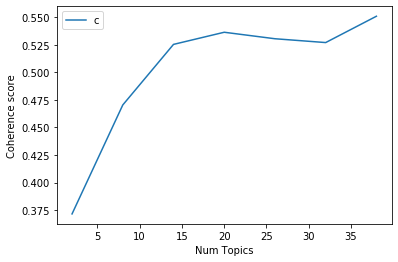

In [35]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3716
Num Topics = 8  has Coherence Value of 0.4704
Num Topics = 14  has Coherence Value of 0.5254
Num Topics = 20  has Coherence Value of 0.5364
Num Topics = 26  has Coherence Value of 0.5305
Num Topics = 32  has Coherence Value of 0.5271
Num Topics = 38  has Coherence Value of 0.551


In [44]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.021*"space" + 0.012*"system" + 0.009*"launch" + 0.009*"project" + '
  '0.008*"design" + 0.008*"technology" + 0.007*"model" + 0.007*"base" + '
  '0.007*"material" + 0.006*"satellite"'),
 (1,
  '0.041*"car" + 0.016*"bike" + 0.011*"ride" + 0.010*"engine" + 0.009*"turn" + '
  '0.009*"good" + 0.009*"drive" + 0.008*"time" + 0.008*"speed" + 0.007*"back"'),
 (2,
  '0.191*"ax" + 0.158*"line" + 0.154*"max" + 0.067*"host" + 0.026*"nntp_poste" '
  '+ 0.019*"ca" + 0.018*"reply" + 0.011*"keyword" + 0.010*"distribution_usa" + '
  '0.009*"printer"'),
 (3,
  '0.021*"people" + 0.018*"time" + 0.018*"happen" + 0.014*"start" + '
  '0.014*"leave" + 0.013*"back" + 0.012*"day" + 0.012*"thing" + 0.011*"hear" + '
  '0.010*"live"'),
 (4,
  '0.017*"exist" + 0.015*"claim" + 0.013*"question" + 0.013*"reason" + '
  '0.013*"true" + 0.013*"argument" + 0.011*"evidence" + 0.011*"make" + '
  '0.010*"thing" + 0.009*"science"'),
 (5,
  '0.242*"write" + 0.157*"article" + 0.129*"line" + 0.066*"organization" + '
  '

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1909,"car, bike, ride, engine, turn, good, drive, ti...",From: (wheres my thing) Subject: WHAT car is t...
1,1,16.0,0.1458,"drive, card, system, problem, bit, work, drive...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,16.0,0.1197,"drive, card, system, problem, bit, work, drive...",From: (Thomas E Willis) Subject: PB questions....
3,3,5.0,0.1019,"write, article, line, organization, host, hear...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,8.0,0.1767,"window, run, set, application, display, proble...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,11.0,0.3061,"gun, law, case, state, fire, kill, crime, weap...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,9.0,0.1332,"post, read, question, find, group, line, point...",From: (brian manning delaney) Subject: Brain T...
7,7,16.0,0.4945,"drive, card, system, problem, bit, work, drive...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,8.0,0.0979,"window, run, set, application, display, proble...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,16.0,0.1892,"drive, card, system, problem, bit, work, drive...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [46]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7349,"space, system, launch, project, design, techno...",From: (Jon Leech) Subject: Space FAQ 11/15 - U...
1,1.0,0.5363,"car, bike, ride, engine, turn, good, drive, ti...",From: (richard welty) Subject: rec.autos: Freq...
2,2.0,0.9712,"ax, line, max, host, nntp_poste, ca, reply, ke...",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
3,3.0,0.8311,"people, time, happen, start, leave, back, day,...",From: (David Davidian) Subject: Accounts of An...
4,4.0,0.6799,"exist, claim, question, reason, true, argument...",From: mathew Subject: Alt.Atheism FAQ: Constru...


In [47]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"car, bike, ride, engine, turn, good, drive, ti...",484.0,0.0428
1.0,16.0,"drive, card, system, problem, bit, work, drive...",885.0,0.0782
2.0,16.0,"drive, card, system, problem, bit, work, drive...",342.0,0.0302
3.0,5.0,"write, article, line, organization, host, hear...",262.0,0.0232
4.0,8.0,"window, run, set, application, display, proble...",465.0,0.0411
...,...,...,...,...
11309.0,15.0,"problem, drug, study, food, effect, doctor, pa...",NaN,NaN
11310.0,19.0,"power, line, current, ground, work, wire, wate...",NaN,NaN
11311.0,16.0,"drive, card, system, problem, bit, work, drive...",NaN,NaN
11312.0,9.0,"post, read, question, find, group, line, point...",NaN,NaN


https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/